# Haystack Building Blocks

## Installing Haystack

Install Haystack and other required packages with `pip`:

In [1]:
%%bash

pip install haystack-ai
pip install "datasets>=2.6.1"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.2/419.2 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.1/95.1 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12 12.5.82 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-runtime-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-runtime-cu12 12.5.82

In [15]:
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.generators.chat import AzureOpenAIChatGenerator

from google.colab import userdata
from haystack.utils import Secret
from haystack.dataclasses import ChatMessage
from haystack.components.builders import ChatPromptBuilder

from haystack.components.embedders import AzureOpenAIDocumentEmbedder

from haystack.components.generators.chat import AzureOpenAIChatGenerator
from haystack.components.embedders import AzureOpenAITextEmbedder


In [16]:
document_store = InMemoryDocumentStore()

## Define Prompt Builder

In [32]:
template = [
    ChatMessage.from_user(
        """
        Given the following information, answer the question.

        context:
        {% for document in documents %}
        {{ document.content }}
        {% endfor %}

        Question: {{question}}
        Answer:
        """
    )
]

prompt_builder = ChatPromptBuilder(template = template)

## Load the Azure Components

In [33]:
doc_embedder = AzureOpenAIDocumentEmbedder(
                              azure_endpoint = userdata.get("ada_end_point"),
                             api_key = Secret.from_token(userdata.get("api_key")),
                             azure_deployment = "text-embedding-ada-002"

)


chat_generator = AzureOpenAIChatGenerator(azure_endpoint = userdata.get("azure_endpoint"),
                             api_key = Secret.from_token(userdata.get("api_key")),
                             azure_deployment = "gpt-35-turbo"

)

query_embedder = AzureOpenAITextEmbedder(azure_endpoint = userdata.get("ada_end_point"),
                             api_key = Secret.from_token(userdata.get("api_key")),
                             azure_deployment = "text-embedding-ada-002")

In [34]:
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever

In [35]:
retriever = InMemoryEmbeddingRetriever(document_store)

## Indexing pipelines

In [36]:
from haystack.components.converters.txt import TextFileToDocument
from haystack.components.preprocessors.document_splitter import DocumentSplitter
from haystack.components.writers import DocumentWriter

In [37]:
converter = TextFileToDocument()
splitter = DocumentSplitter()
writer = DocumentWriter(document_store = document_store)

## Creating Pipelines

In [38]:
from haystack import Pipeline

In [39]:
indexing_pipeline = Pipeline()
indexing_pipeline.add_component("converter", converter)
indexing_pipeline.add_component("splitter", splitter)
indexing_pipeline.add_component("embedder", doc_embedder)
indexing_pipeline.add_component("writer", writer)

In [40]:
indexing_pipeline.connect("converter.documents", "splitter.documents")
indexing_pipeline.connect("splitter", "embedder")
indexing_pipeline.connect("embedder", "writer")

🚅 Components
  - converter: TextFileToDocument
  - splitter: DocumentSplitter
  - embedder: AzureOpenAIDocumentEmbedder
  - writer: DocumentWriter
🛤️ Connections
  - converter.documents -> splitter.documents (List[Document])
  - splitter.documents -> embedder.documents (List[Document])
  - embedder.documents -> writer.documents (List[Document])

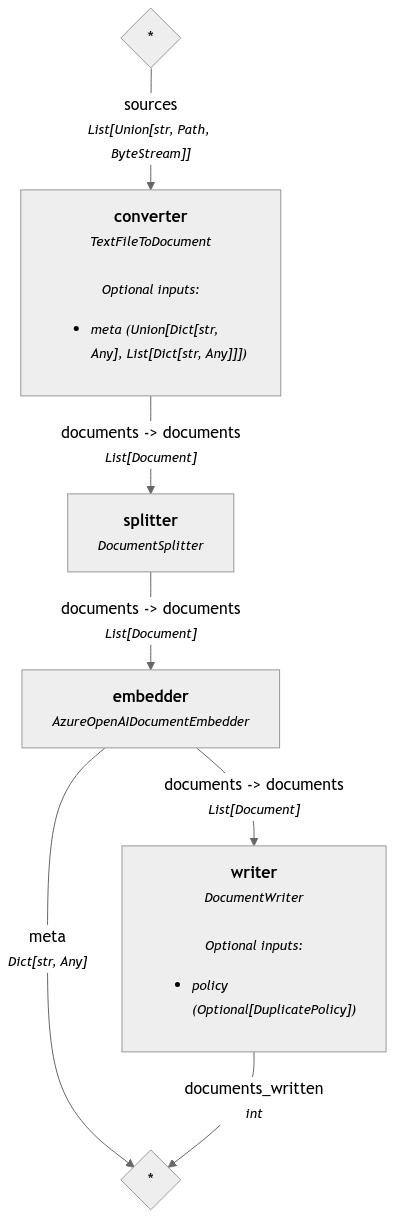

In [43]:
indexing_pipeline.show()

In [44]:
indexing_pipeline.run({"converter": {"sources": ['davinci.txt']}})

Embedding Texts: 100%|██████████| 37/37 [01:09<00:00,  1.89s/it]


{'embedder': {'meta': {'model': 'text-embedding-ada-002',
   'usage': {'prompt_tokens': 340507, 'total_tokens': 340507}}},
 'writer': {'documents_written': 1163}}

## Querying Pipeline

In [59]:
doc_embedder = AzureOpenAIDocumentEmbedder(
                              azure_endpoint = userdata.get("ada_end_point"),
                             api_key = Secret.from_token(userdata.get("api_key")),
                             azure_deployment = "text-embedding-ada-002"

)


chat_generator = AzureOpenAIChatGenerator(azure_endpoint = userdata.get("azure_endpoint"),
                             api_key = Secret.from_token(userdata.get("api_key")),
                             azure_deployment = "gpt-35-turbo"

)

query_embedder = AzureOpenAITextEmbedder(azure_endpoint = userdata.get("ada_end_point"),
                             api_key = Secret.from_token(userdata.get("api_key")),
                             azure_deployment = "text-embedding-ada-002")

retriever = InMemoryEmbeddingRetriever(document_store)

prompt_builder = ChatPromptBuilder(template = template)

In [60]:
 basic_rag_pipeline = Pipeline()

In [ ]:
template = [
    ChatMessage.from_user(
        """
        Given the following information, answer the question.

        context:
        {% for document in documents %}
        {{ document.content }}
        {% endfor %}

        Question: {{question}}
        Answer:
        """
    )
]

prompt_builder = ChatPromptBuilder(template = template)

In [61]:
basic_rag_pipeline.add_component("text_embedder", query_embedder)

basic_rag_pipeline.add_component("retriever", retriever)

basic_rag_pipeline.add_component("prompt_builder", prompt_builder)

basic_rag_pipeline.add_component("llm", chat_generator)

In [63]:
basic_rag_pipeline.connect("text_embedder.embedding", "retriever.query_embedding")

basic_rag_pipeline.connect("retriever", "prompt_builder")

basic_rag_pipeline.connect("prompt_builder.prompt", "llm.messages")

🚅 Components
  - text_embedder: AzureOpenAITextEmbedder
  - retriever: InMemoryEmbeddingRetriever
  - prompt_builder: ChatPromptBuilder
  - llm: AzureOpenAIChatGenerator
🛤️ Connections
  - text_embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> llm.messages (List[ChatMessage])

## question --> embedding --> retrieval --> prompt_builder --> llm --> answer generation

In [68]:
question = "Tell me about Da Vinci"

In [69]:
response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

In [70]:
response

{'text_embedder': {'meta': {'model': 'text-embedding-ada-002',
   'usage': {'prompt_tokens': 5, 'total_tokens': 5}}},
 'llm': {'replies': [ChatMessage(_role=<ChatRole.ASSISTANT: 'assistant'>, _content=[TextContent(text='Da Vinci was a famous artist and inventor during the Renaissance period. He is well known for works such as the Mona Lisa and The Last Supper, but also left behind numerous manuscript texts on various subjects such as anatomy, physics, and botany. Many of his works were not completed for various reasons, such as the Sforza Monument and the Battle of Anghiari wall painting. He had a great interest in studying and understanding the natural world, and his work has had a significant influence on both art and science.')], _name=None, _meta={'model': 'gpt-35-turbo', 'index': 0, 'finish_reason': 'stop', 'usage': {'completion_tokens': 105, 'prompt_tokens': 3550, 'total_tokens': 3655, 'completion_tokens_details': None, 'prompt_tokens_details': None}})]}}

In [74]:
question = "What are the famous paintings of Da vinci?"

In [75]:
response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

In [76]:
response

{'text_embedder': {'meta': {'model': 'text-embedding-ada-002',
   'usage': {'prompt_tokens': 10, 'total_tokens': 10}}},
 'llm': {'replies': [ChatMessage(_role=<ChatRole.ASSISTANT: 'assistant'>, _content=[TextContent(text='The three most important paintings by Da Vinci are the Sforza Monument and the Wall-painting of the Battle of Anghiari, which were never completed, and the painting of the Last Supper at Milan, which has suffered irreparable damage from decay and repeated restorations. However, he is also known for other paintings like the Adoration of the Magi (unfinished), La Vierge aux Rochers, and Mona Lisa.')], _name=None, _meta={'model': 'gpt-35-turbo', 'index': 0, 'finish_reason': 'stop', 'usage': {'completion_tokens': 88, 'prompt_tokens': 3186, 'total_tokens': 3274, 'completion_tokens_details': None, 'prompt_tokens_details': None}})]}}